In [55]:
import requests
import json
import pandas as pd
import os
import re
import time
from tqdm import tqdm
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

In [36]:
USERNAME = "santagata.l@northeastern.edu"
PASSWORD = "FAJX13Zm"

auth = (USERNAME, PASSWORD)

## Downlaod events

In [37]:
# --- Parametri ---
COMPETITION_ID = 9
SEASON_ID = 317
OUT_DIR = "Bundesliga_24_25_matches"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Endpoints base ---
BASE_V8 = "https://data.statsbomb.com/api/v8"
BASE_V4 = "https://data.statsbomb.com/api/v4"  # fallback se serve

def safe_name(s: str) -> str:
    s = (s or "").strip()
    s = re.sub(r"[\\/:*?\"<>|]+", "-", s)
    s = re.sub(r"\s+", " ", s)
    return s

def get_json(url: str, auth=None, max_retries=5, backoff=1.5):
    for attempt in range(1, max_retries + 1):
        r = requests.get(url, auth=auth)
        if r.status_code == 200:
            return r.json()
        if r.status_code in (429, 500, 502, 503, 504):
            time.sleep(backoff ** attempt)
            continue
        # per 4xx diversi da 429 restituisco None (es. 404) così si prova un altro endpoint
        if 400 <= r.status_code < 500:
            return None
        raise RuntimeError(f"Errore {r.status_code}: {r.text}")
    return None

def fetch_matches(competition_id: int, season_id: int):
    candidates = [
        f"{BASE_V8}/competitions/{competition_id}/seasons/{season_id}/matches",
        f"{BASE_V8}/matches?competition_id={competition_id}&season_id={season_id}",
        f"{BASE_V4}/competitions/{competition_id}/seasons/{season_id}/matches",
        f"{BASE_V4}/matches/{competition_id}/{season_id}",
    ]
    for url in candidates:
        data = get_json(url, auth=auth)
        if isinstance(data, list) and data:
            return data
    raise RuntimeError("Impossibile ottenere la lista match (404/4xx su tutti gli endpoint provati).")

# 1) Scarica lista partite
matches = fetch_matches(COMPETITION_ID, SEASON_ID)

# 2) Loop e salva eventi v8: /api/v8/events/{match_id}
for m in tqdm(matches, desc="Scarico eventi", unit="match"):
    match_id = m.get("match_id")
    home = (
        (m.get("home_team") or {}).get("home_team_name")
        or (m.get("home_team") or {}).get("name")
        or m.get("home_team_name")
        or "Home"
    )
    away = (
        (m.get("away_team") or {}).get("away_team_name")
        or (m.get("away_team") or {}).get("name")
        or m.get("away_team_name")
        or "Away"
    )

    fname = f"{safe_name(home)}_{safe_name(away)}_{match_id}.json"
    fpath = os.path.join(OUT_DIR, fname)
    if os.path.exists(fpath):
        continue

    events_url = f"{BASE_V8}/events/{match_id}"
    events = get_json(events_url, auth=auth)
    if not isinstance(events, list):
        # se gli eventi non sono disponibili in v8, salto
        continue

    with open(fpath, "w", encoding="utf-8") as f:
        json.dump(events, f, ensure_ascii=False, indent=2)

    time.sleep(0.2)  # piccolo delay gentile

Scarico eventi: 100%|██████████| 306/306 [18:38<00:00,  3.65s/match]


In [8]:
# Cartelle da scansionare
FOLDERS = ["Serie_A_24_25", "La_Liga_24_25", "Premier_League_24_25"]

unique_types = set()

# Raccogli tutti i file JSON
all_files = []
for folder in FOLDERS:
    if os.path.exists(folder):
        all_files.extend([
            os.path.join(folder, f)
            for f in os.listdir(folder)
            if f.endswith(".json")
        ])

# Scansiona i file con barra di progresso
for path in tqdm(all_files, desc="Analisi JSON", unit="file"):
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)

        # Ogni file è una lista di eventi
        if isinstance(data, list):
            for event in data:
                if "type" in event and isinstance(event["type"], dict):
                    name = event["type"].get("name")
                    if name:
                        unique_types.add(name)

    except Exception as e:
        tqdm.write(f"Errore nel file {os.path.basename(path)}: {e}")

# Ordina e stampa i type.name unici
unique_types = sorted(unique_types)
print(f"\n✅ Trovati {len(unique_types)} type.name unici:\n")
for t in unique_types:
    print(t)

Analisi JSON: 100%|██████████| 1140/1140 [03:03<00:00,  6.22file/s]


✅ Trovati 33 type.name unici:

50/50
Bad Behaviour
Ball Receipt*
Ball Recovery
Block
Carry
Clearance
Dispossessed
Dribble
Dribbled Past
Duel
Error
Foul Committed
Foul Won
Goal Keeper
Half End
Half Start
Injury Stoppage
Interception
Miscontrol
Offside
Own Goal Against
Own Goal For
Pass
Player Off
Player On
Pressure
Referee Ball-Drop
Shield
Shot
Starting XI
Substitution
Tactical Shift


## Building dfs

In [56]:
# --- Constants ---
SKIP_TYPES = {"Half End", "Half Start", "Referee Ball Drop", "Starting XI"}

# --- Helpers ---
def safe_key(s: str) -> str:
    return re.sub(r"\W+", "_", (s or "").strip())

def parse_match_id_from_filename(path: str) -> str:
    m = re.search(r"_([0-9]+)\.json$", os.path.basename(path))
    return m.group(1) if m else "unknown"

# --- Core logic (updated to also track players) ---
def build_team_sequences(events):
    """
    Collects sequences of type.name for each team, split by team switches,
    and also collects the corresponding player names in the same order.
    Returns:
      sequences: { team_id: [ {"words":[...], "players":[...]}, ... ] }
      id_to_name: { team_id: team_name }
    """
    id_to_name = {}
    sequences = {}
    current_team = None
    buffer_words = []
    buffer_players = []

    for ev in events:
        team = ev.get("team") or {}
        team_id = team.get("id")
        team_name = team.get("name")
        if team_id is None or team_name is None:
            continue

        id_to_name[team_id] = team_name

        t = ev.get("type")
        tname = t.get("name") if isinstance(t, dict) else None
        # Normalize "Ball Receipt*"
        if tname == "Ball Receipt*":
            tname = "Ball Receipt"

        # Skip unwanted event types
        if tname in SKIP_TYPES or tname is None:
            continue

        # Player name (align one-to-one with the event in words)
        player_name = (ev.get("player") or {}).get("name") or "Unknown"

        if current_team is None:
            # First seen team
            current_team = team_id
            buffer_words.append(tname)
            buffer_players.append(player_name)
            continue

        if team_id == current_team:
            # Same team → keep accumulating
            buffer_words.append(tname)
            buffer_players.append(player_name)
        else:
            # Team switch → flush previous run
            if buffer_words:
                sequences.setdefault(current_team, []).append(
                    {"words": buffer_words[:], "players": buffer_players[:]}
                )
            # Start a new run for the new team
            current_team = team_id
            buffer_words = [tname]
            buffer_players = [player_name]

    # Flush last pending run
    if current_team is not None and buffer_words:
        sequences.setdefault(current_team, []).append(
            {"words": buffer_words[:], "players": buffer_players[:]}
        )

    return sequences, id_to_name

def runs_to_df(runs, match_id, team_name):
    """
    Turns a list of runs (each run has 'words' and 'players') into a DataFrame.
    - 'words' are concatenated with '-'
    - 'word_players' mirrors 'words' order and is also concatenated with '-'
    """
    rows = []
    for run in runs:
        words = list(run.get("words") or [])
        players = list(run.get("players") or [])
        if not words:
            continue
        # Ensure equal length; if somehow mismatched, pad players with "Unknown"
        if len(players) < len(words):
            players = players + ["Unknown"] * (len(words) - len(players))
        rows.append({
            "words": "-".join(words),
            "word_players": "-".join(players),
            "match_id": match_id,
            "team_name": team_name,
        })
    return pd.DataFrame(rows, columns=["words", "word_players", "match_id", "team_name"])

def process_match_file(path):
    """
    Processes a single StatsBomb JSON file and returns two DataFrames (one per team).
    Each DF has: words, word_players, match_id, team_name.
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    events = data if isinstance(data, list) else data.get("events", [])
    if not events:
        print(f"Nessun evento trovato in {path}")
        return None, None

    sequences, id_to_name = build_team_sequences(events)
    match_id = parse_match_id_from_filename(path)

    dfs = []
    for team_id, runs in sequences.items():
        team_name = id_to_name.get(team_id, f"Team{team_id}")
        df = runs_to_df(runs, match_id, team_name)
        dfs.append(df)

    if len(dfs) == 2:
        return dfs[0], dfs[1]
    elif len(dfs) == 1:
        return dfs[0], None
    else:
        return None, None

In [57]:
json_path = "Serie_A_24_25_matches/AC Milan_AS Roma_3945135.json"

team1_df, team2_df = process_match_file(json_path)

In [58]:
team1_df.head(15)

,words,word_players,match_id,team_name
0,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Pass-Ball Receipt,Paulo Bruno Exequiel Dybala-Leandro Daniel Paredes-Leandro Daniel Paredes-Leandro Daniel Paredes-Gianluca Mancini-Gianluca Mancini-Gianluca Mancini-Alexis Saelemaekers-Alexis Saelemaekers-Alexis Saelemaekers-Leandro Daniel Paredes-Leandro Daniel Paredes-Paulo Bruno Exequiel Dybala,3945135,AS Roma
1,Pass,Alexis Saelemaekers,3945135,AS Roma
2,Ball Receipt-Carry-Pass-Ball Receipt,Leandro Daniel Paredes-Leandro Daniel Paredes-Leandro Daniel Paredes-Alexis Saelemaekers,3945135,AS Roma
3,Pressure,José Ángel Esmoris Tasende,3945135,AS Roma
4,Pressure,Kouadio Emmanuel Koné,3945135,AS Roma
5,Pressure,Mats Hummels,3945135,AS Roma
6,Duel-Clearance,Mats Hummels-Mile Svilar,3945135,AS Roma
7,Pressure,Niccolò Pisilli,3945135,AS Roma
8,Pass-Ball Receipt-Carry,Leandro Daniel Paredes-Alexis Saelemaekers-Alexis Saelemaekers,3945135,AS Roma
9,Foul Won-Pass-Ball Receipt-Carry-Pass,Alexis Saelemaekers-Alexis Saelemaekers-Leandro Daniel Paredes-Leandro Daniel Paredes-Leandro Daniel Paredes,3945135,AS Roma


In [59]:
team2_df.to_csv("Milan.csv", index=False)

In [60]:
team2_df.head(15)

,words,word_players,match_id,team_name
0,Clearance,Malick Thiaw,3945135,AC Milan
1,Pressure,Filippo Terracciano,3945135,AC Milan
2,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry,Theo Bernard François Hernández-Malick Thiaw-Malick Thiaw-Malick Thiaw-Mike Maignan-Mike Maignan-Mike Maignan-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan
3,Pass,Samuel Chimerenka Chukwueze,3945135,AC Milan
4,Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass,Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Mike Maignan-Mike Maignan-Mike Maignan-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan
5,Ball Receipt-Carry-Dispossessed,Tijjani Reijnders-Tijjani Reijnders-Tijjani Reijnders,3945135,AC Milan
6,Pass-Ball Receipt-Pass-Ball Receipt-Carry,Emerson Aparecido Leite de Souza Junior-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Youssouf Fofana-Youssouf Fofana,3945135,AC Milan
7,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt,Youssouf Fofana-Malick Thiaw-Malick Thiaw-Malick Thiaw-Theo Bernard François Hernández-Theo Bernard François Hernández-Theo Bernard François Hernández-Malick Thiaw-Malick Thiaw-Malick Thiaw-Theo Bernard François Hernández,3945135,AC Milan
8,Pressure-Foul Committed,Filippo Terracciano-Filippo Terracciano,3945135,AC Milan
9,Pressure,Theo Bernard François Hernández,3945135,AC Milan


# !!! Create texts

In [80]:
INPUT_DIR  = "Premier_League_24_25_matches"
OUTPUT_DIR = "Premier_League_24_25_texts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def save_team_df(df: pd.DataFrame):
    """Salva df in OUTPUT_DIR come team_matchid.csv"""
    if df is None or df.empty:
        return False
    team_name = str(df.iloc[0]["team_name"])
    match_id  = str(df.iloc[0]["match_id"])
    out_name  = f"{safe_key(team_name)}_{match_id}.csv"
    out_path  = os.path.join(OUTPUT_DIR, out_name)
    df.to_csv(out_path, index=False, encoding="utf-8")
    return True

processed = saved = skipped = 0
json_files = sorted(glob(os.path.join(INPUT_DIR, "*.json")))

# 🔁 Iterazione con tqdm
for path in tqdm(json_files, desc="Processing matches", unit="file"):
    try:
        df1, df2 = process_match_file(path)
        processed += 1

        ok1 = save_team_df(df1) if df1 is not None else False
        ok2 = save_team_df(df2) if df2 is not None else False

        if ok1: saved += 1
        if ok2: saved += 1
        if not ok1 and not ok2:
            skipped += 1
            tqdm.write(f"⚠️  Nessun DF valido per: {os.path.basename(path)}")
    except Exception as e:
        skipped += 1
        tqdm.write(f"❌ Errore su {os.path.basename(path)}: {e}")

print("\n✅ FATTO")
print(f"JSON processati: {processed}")
print(f"CSV salvati    : {saved}")
print(f"File saltati   : {skipped}")

Processing matches: 100%|██████████| 380/380 [02:22<00:00,  2.66file/s]


✅ FATTO
JSON processati: 380
CSV salvati    : 760
File saltati   : 0


In [62]:
df = pd.read_csv("Serie_A_24_25_texts/AC_Milan_3945070.csv")

In [63]:
df.head(15)

,words,word_players,match_id,team_name
0,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Pass-Ball Receipt,Emerson Aparecido Leite de Souza Junior-Christian Pulisic-Christian Pulisic-Christian Pulisic-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Samuel Chimerenka Chukwueze,3945070,AC Milan
1,Block,Emerson Aparecido Leite de Souza Junior,3945070,AC Milan
2,Pressure,Strahinja Pavlović,3945070,AC Milan
3,Goal Keeper,Mike Maignan,3945070,AC Milan
4,Goal Keeper-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry,Mike Maignan-Francesco Camarda-Youssouf Fofana-Youssouf Fofana-Youssouf Fofana-Tijjani Reijnders-Tijjani Reijnders-Tijjani Reijnders-Malick Thiaw-Malick Thiaw-Malick Thiaw-Strahinja Pavlović-Strahinja Pavlović-Strahinja Pavlović-Mike Maignan-Mike Maignan-Mike Maignan-Youssouf Fofana-Youssouf Fofana,3945070,AC Milan
5,Pass-Ball Receipt-Carry-Pass-Pressure-Ball Receipt,Youssouf Fofana-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Christian Pulisic-Christian Pulisic,3945070,AC Milan
6,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry,Samuel Chimerenka Chukwueze-Christian Pulisic-Christian Pulisic-Christian Pulisic-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945070,AC Milan
7,Pass-Ball Receipt-Carry,Samuel Chimerenka Chukwueze-Christian Pulisic-Christian Pulisic,3945070,AC Milan
8,Pass-Ball Receipt-Carry,Christian Pulisic-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior,3945070,AC Milan
9,Pass,Emerson Aparecido Leite de Souza Junior,3945070,AC Milan


## assign victory

In [81]:
COMPETITION_ID = 2
SEASON_ID = 317
INPUT_DIR = "Premier_League_24_25_texts"

# === 1️⃣ Scarica le info delle partite (home/away + punteggi) ===
url = f"https://data.statsbomb.com/api/v6/competitions/{COMPETITION_ID}/seasons/{SEASON_ID}/matches"

with tqdm(total=1, desc="Download API", unit="request") as pbar:
    response = requests.get(url, auth=auth)
    pbar.update(1)

if response.status_code != 200:
    raise RuntimeError(f"Errore {response.status_code}: {response.text}")

matches = response.json()

# Crea dizionario {match_id: info partita}
match_dict = {}
for m in matches:
    match_dict[m["match_id"]] = {
        "home_team": m["home_team"]["home_team_name"],
        "away_team": m["away_team"]["away_team_name"],
        "home_score": m["home_score"],
        "away_score": m["away_score"],
    }

print(f"✅ Caricate {len(match_dict)} partite da API StatsBomb\n")

# === 2️⃣ Itera su tutti i CSV ===
csv_files = sorted(glob(os.path.join(INPUT_DIR, "*.csv")))

for path in tqdm(csv_files, desc="Aggiornamento CSV", unit="file"):
    try:
        df = pd.read_csv(path)
        match_id = int(df.iloc[0]["match_id"])
        team = df.iloc[0]["team_name"]

        if match_id not in match_dict:
            tqdm.write(f"⚠️  Match {match_id} non trovato nei dati API")
            continue

        info = match_dict[match_id]
        home_team = info["home_team"]
        away_team = info["away_team"]
        hs, as_ = info["home_score"], info["away_score"]

        # Determina outcome
        if hs == as_:
            outcome = "Drawn"
        elif (team == home_team and hs > as_) or (team == away_team and as_ > hs):
            outcome = "Won"
        else:
            outcome = "Lost"

        df["outcome"] = outcome

        # Sovrascrive il CSV
        df.to_csv(path, index=False, encoding="utf-8")

    except Exception as e:
        tqdm.write(f"❌ Errore su {os.path.basename(path)}: {e}")

print("\n✅ Tutti i CSV aggiornati con colonna 'outcome'!")

Download API: 100%|██████████| 1/1 [00:01<00:00,  1.08s/request]


✅ Caricate 380 partite da API StatsBomb



Aggiornamento CSV: 100%|██████████| 760/760 [00:18<00:00, 40.41file/s]


✅ Tutti i CSV aggiornati con colonna 'outcome'!


In [65]:
df = pd.read_csv("Serie_A_24_25_texts/AC_Milan_3945135.csv")
df.head()

,words,word_players,match_id,team_name,outcome
0,Clearance,Malick Thiaw,3945135,AC Milan,Drawn
1,Pressure,Filippo Terracciano,3945135,AC Milan,Drawn
2,Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry,Theo Bernard François Hernández-Malick Thiaw-Malick Thiaw-Malick Thiaw-Mike Maignan-Mike Maignan-Mike Maignan-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan,Drawn
3,Pass,Samuel Chimerenka Chukwueze,3945135,AC Milan,Drawn
4,Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass-Ball Receipt-Carry-Pass,Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Emerson Aparecido Leite de Souza Junior-Matteo Gabbia-Matteo Gabbia-Matteo Gabbia-Mike Maignan-Mike Maignan-Mike Maignan-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Álvaro Borja Morata Martín-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze-Samuel Chimerenka Chukwueze,3945135,AC Milan,Drawn


## Assign goal

In [82]:
COMPETITION_ID = 2
SEASON_ID = 317
INPUT_DIR = "Premier_League_24_25_texts"

# === 1️⃣ Scarica le info delle partite (home/away + punteggi) ===
url = f"https://data.statsbomb.com/api/v6/competitions/{COMPETITION_ID}/seasons/{SEASON_ID}/matches"

with tqdm(total=1, desc="Download API", unit="request") as pbar:
    response = requests.get(url, auth=auth)
    pbar.update(1)

if response.status_code != 200:
    raise RuntimeError(f"Errore {response.status_code}: {response.text}")

matches = response.json()

# Crea dizionario {match_id: info partita}
match_dict = {}
for m in matches:
    match_dict[m["match_id"]] = {
        "home_team": m["home_team"]["home_team_name"],
        "away_team": m["away_team"]["away_team_name"],
        "home_score": m["home_score"],
        "away_score": m["away_score"],
    }

print(f"✅ Caricate {len(match_dict)} partite da API StatsBomb\n")

# === 2️⃣ Itera su tutti i CSV ===
csv_files = sorted(glob(os.path.join(INPUT_DIR, "*.csv")))

for path in tqdm(csv_files, desc="Aggiornamento CSV", unit="file"):
    try:
        df = pd.read_csv(path)
        match_id = int(df.iloc[0]["match_id"])
        team = df.iloc[0]["team_name"]

        if match_id not in match_dict:
            tqdm.write(f"⚠️  Match {match_id} non trovato nei dati API")
            continue

        info = match_dict[match_id]
        home_team = info["home_team"]
        away_team = info["away_team"]
        hs, as_ = info["home_score"], info["away_score"]

        # --- Outcome ---
        if hs == as_:
            outcome = "Drawn"
        elif (team == home_team and hs > as_) or (team == away_team and as_ > hs):
            outcome = "Won"
        else:
            outcome = "Lost"

        # --- Goals scored / conceded ---
        if team == home_team:
            goals_scored = hs
            goals_conceded = as_
        elif team == away_team:
            goals_scored = as_
            goals_conceded = hs
        else:
            tqdm.write(f"⚠️  Squadra '{team}' non corrisponde a home/away nel match {match_id}")
            continue

        # Aggiungi colonne
        df["outcome"] = outcome
        df["goals_scored"] = goals_scored
        df["goals_conceded"] = goals_conceded

        # Sovrascrive il CSV
        df.to_csv(path, index=False, encoding="utf-8")

    except Exception as e:
        tqdm.write(f"❌ Errore su {os.path.basename(path)}: {e}")

print("\n✅ Tutti i CSV aggiornati con 'outcome', 'goals_scored' e 'goals_conceded'!")

Download API: 100%|██████████| 1/1 [00:00<00:00,  1.02request/s]


✅ Caricate 380 partite da API StatsBomb



Aggiornamento CSV: 100%|██████████| 760/760 [00:30<00:00, 24.92file/s]


✅ Tutti i CSV aggiornati con 'outcome', 'goals_scored' e 'goals_conceded'!


In [45]:
df = pd.read_csv("Bundesliga_24_25_texts/Augsburg_3949647.csv")
df.head()

,words,match_id,team_name,outcome,goals_scored,goals_conceded
0,Pass-Ball Receipt,3949647,Augsburg,Won,2,1
1,Interception-Carry,3949647,Augsburg,Won,2,1
2,Pass,3949647,Augsburg,Won,2,1
3,Ball Receipt-Carry-Miscontrol-Pressure,3949647,Augsburg,Won,2,1
4,Block,3949647,Augsburg,Won,2,1


## Assign season

In [83]:
# --- Config ---
COMPETITION_ID = 2   
SEASON_ID = 317       # 2024/25
INPUT_DIR = "Premier_League_24_25_texts"  # cartella dei CSV per match
# Assumo che 'auth' (USERNAME, PASSWORD) sia già definito: auth = (USERNAME, PASSWORD)

# 1) Scarica matchweek per ogni match_id
url = f"https://data.statsbomb.com/api/v6/competitions/{COMPETITION_ID}/seasons/{SEASON_ID}/matches"
with tqdm(total=1, desc="Download API", unit="request") as pbar:
    resp = requests.get(url, auth=auth)
    pbar.update(1)

resp.raise_for_status()
matches = resp.json()

# Dizionario: match_id -> match_week
week_by_match = {m["match_id"]: m.get("match_week") for m in matches}

# 2) Aggiorna ciascun CSV aggiungendo 'season_half'
csv_files = sorted(glob(os.path.join(INPUT_DIR, "*.csv")))
for path in tqdm(csv_files, desc="Updating CSVs", unit="file"):
    try:
        df = pd.read_csv(path)
        match_id = int(df.iloc[0]["match_id"])

        mw = week_by_match.get(match_id, None)
        if mw is None:
            season_half = "Unknown"
        else:
            season_half = "First half" if mw <= 19 else "Second half"

        df["season_half"] = season_half
        df.to_csv(path, index=False, encoding="utf-8")
    except Exception as e:
        tqdm.write(f"Error on {os.path.basename(path)}: {e}")

print("✅ All CSVs updated with 'season_half'.")

Updating CSVs: 100%|██████████| 760/760 [00:32<00:00, 23.20file/s]

✅ All CSVs updated with 'season_half'.


## Chapters

In [84]:
INPUT_DIR = "Premier_League_24_25_texts"
OUTPUT_DIR = "Premier_League_24_25_chapters"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def safe_key(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip())

# Raccogli tutti i CSV per team
by_team = {}
csv_files = sorted(glob(os.path.join(INPUT_DIR, "*.csv")))

for path in tqdm(csv_files, desc="Reading CSVs", unit="file"):
    try:
        df = pd.read_csv(path)
        if df.empty or "team_name" not in df.columns:
            continue
        team = str(df.iloc[0]["team_name"]).strip()
        by_team.setdefault(team, []).append(df)
    except Exception as e:
        tqdm.write(f"⚠️ Skipped {os.path.basename(path)}: {e}")

# Concatena e salva un CSV per squadra
for team, dfs in tqdm(by_team.items(), desc="Writing team chapters", unit="team"):
    try:
        stacked = pd.concat(dfs, ignore_index=True)
        # (opzionale) ordina per match_id se presente
        if "match_id" in stacked.columns:
            stacked = stacked.sort_values("match_id").reset_index(drop=True)
        out_path = os.path.join(OUTPUT_DIR, f"{safe_key(team)}.csv")
        stacked.to_csv(out_path, index=False, encoding="utf-8")
    except Exception as e:
        tqdm.write(f"❌ Error for team {team}: {e}")

Writing team chapters: 100%|██████████| 20/20 [00:08<00:00,  2.30team/s]


## Heaps Law

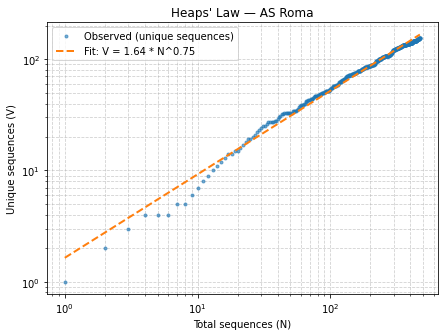

AS Roma: K = 1.64, β = 0.75


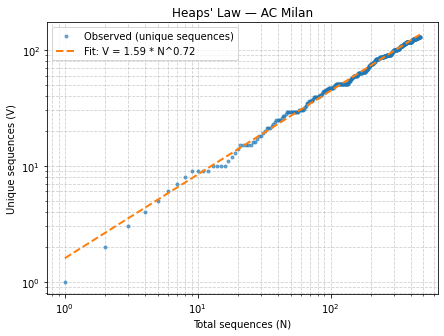

AC Milan: K = 1.59, β = 0.72


(1.5924602531556662, 0.7221925472515905)

In [37]:
def plot_heaps_law(team_df, team_label="Team"):
    """
    Calcola e plotta la Heaps' Law considerando ogni riga del DataFrame come una parola unica.
    Visualizza un punto per ogni riga unique nel dataset.
    """
    # Ogni riga del DataFrame è una "parola" (sequenza completa)
    all_tokens = list(team_df["words"]) #la lista di tutte le righe (sequenze)

    total_words = []
    unique_words = []
    seen = set()

    # Crescita del vocabolario (ogni sequenza = 1 parola)
    for i, token in enumerate(all_tokens, start=1):
        seen.add(token)
        total_words.append(i) #quanti “token” totali (righe) hai visto finora
        unique_words.append(len(seen)) #quante “parole” uniche (sequenze diverse) hai incontrato, es: [1, 1, 2, 3, 3, 3, 3, 4, 4, 4]

    total_words = np.array(total_words)
    unique_words = np.array(unique_words)

    # --- FIT Heaps' Law: log(V) = log(K) + β log(N)
    logN = np.log(total_words)
    logV = np.log(unique_words)
    coeffs = np.polyfit(logN, logV, 1)
    beta, logK = coeffs[0], coeffs[1]
    K = np.exp(logK)

    # Predizione continua
    V_pred = K * total_words ** beta

    # --- PLOT ---
    plt.figure(figsize=(7, 5))
    plt.loglog(total_words, unique_words, ".", alpha=0.6, label="Observed (unique sequences)")
    plt.loglog(total_words, V_pred, "--", lw=2, label=f"Fit: V = {K:.2f} * N^{beta:.2f}")
    plt.xlabel("Total sequences (N)")
    plt.ylabel("Unique sequences (V)")
    plt.title(f"Heaps' Law — {team_label}")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.show()

    print(f"{team_label}: K = {K:.2f}, β = {beta:.2f}")
    return K, beta


# 🔹 Esempio di utilizzo
plot_heaps_law(team1_df, team_label=team1_df.iloc[0]["team_name"])
plot_heaps_law(team2_df, team_label=team2_df.iloc[0]["team_name"])

# Serie_A

Computing Heaps' Law: 100%|██████████| 20/20 [00:03<00:00,  6.47team/s]


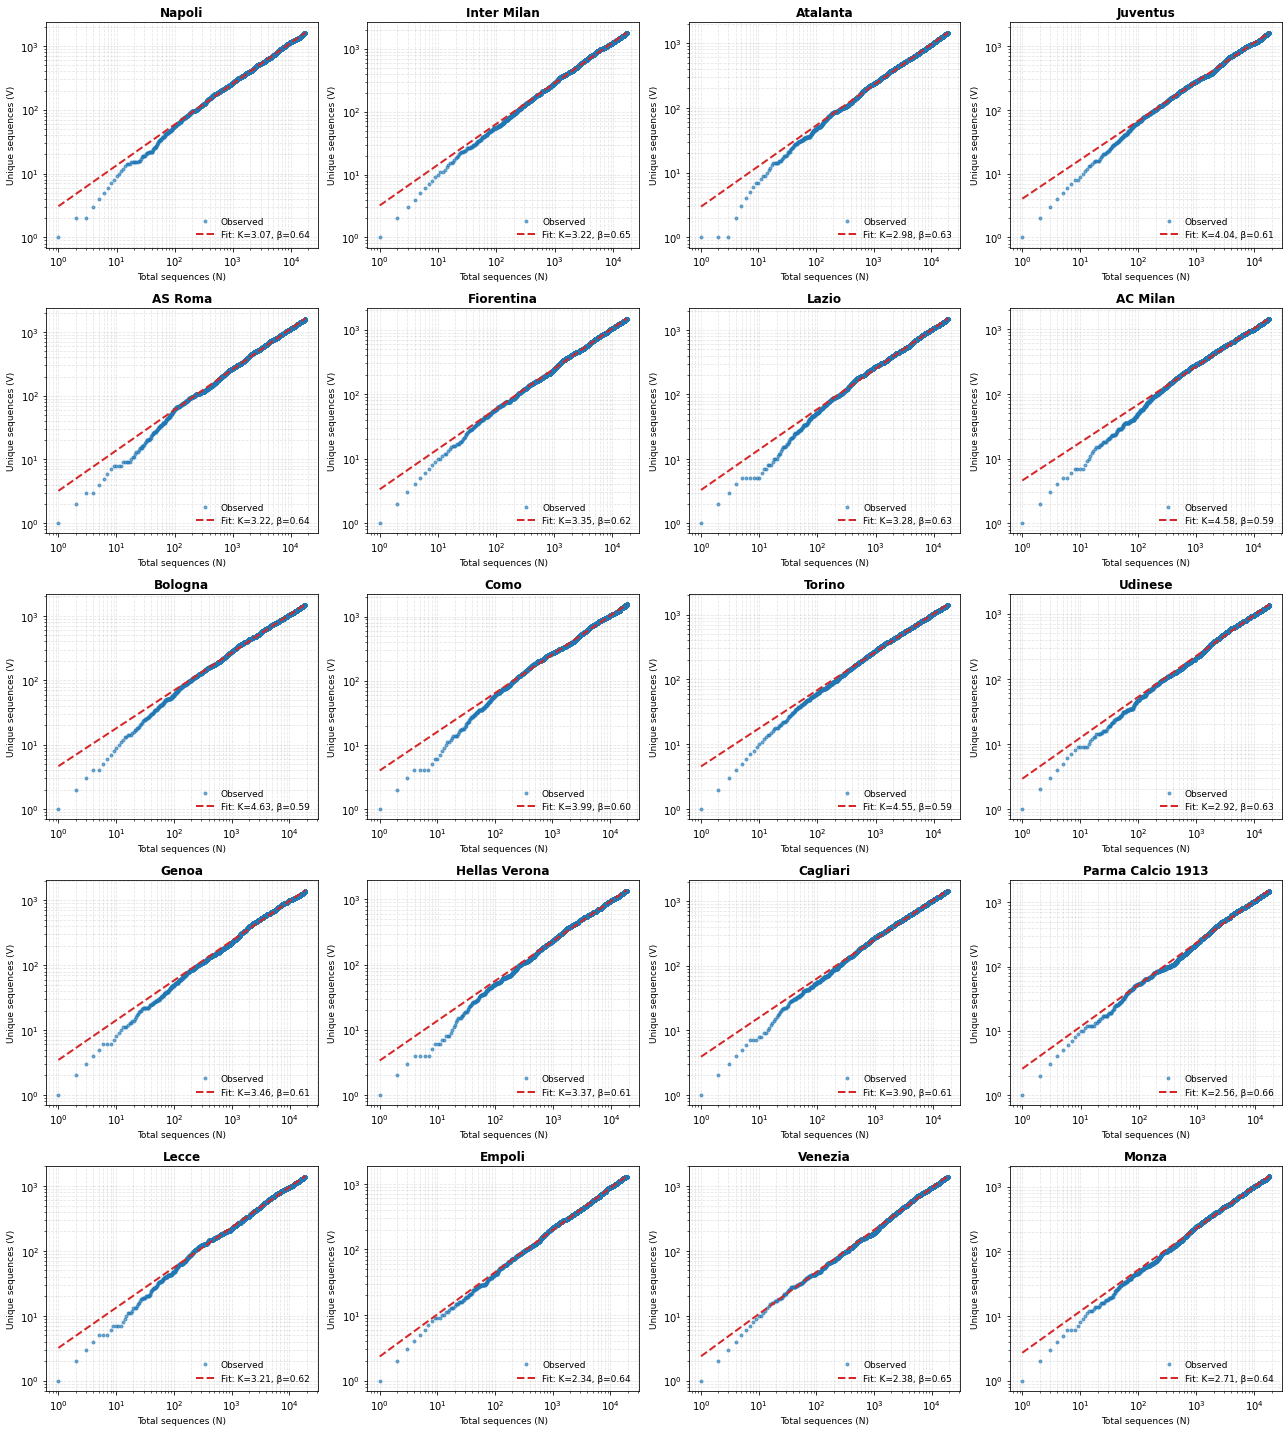

In [31]:
# === Directory con i 20 CSV ===
DIR = "Serie_A_24_25_chapters"

# === Ordine ufficiale delle squadre ===
ranking = [
    "Napoli", 
    "Inter Milan", 
    "Atalanta", 
    "Juventus",
    "AS Roma", 
    "Fiorentina", 
    "Lazio",
    "AC Milan", 
    "Bologna", 
    "Como", 
    "Torino", 
    "Udinese", 
    "Genoa", 
    "Hellas Verona",
    "Cagliari", 
    "Parma Calcio 1913", 
    "Lecce", 
    "Empoli", 
    "Venezia", 
    "Monza",
]

# === Funzione per calcolare Heaps (K, β) ===
def compute_heaps_from_words(words_series):
    tokens = list(words_series.astype(str))
    seen = set()
    total_words, unique_words = [], []
    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)
        unique_words.append(len(seen))
    N = np.array(total_words, dtype=float)
    V = np.array(unique_words, dtype=float)
    mask = (N > 0) & (V > 0)
    if mask.sum() < 5 or np.unique(V[mask]).size < 2:
        return N, V, np.nan, np.nan, None
    logN, logV = np.log(N[mask]), np.log(V[mask])
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)
    V_pred = K * (N ** beta)
    return N, V, K, beta, V_pred

# === Mappa {team_name : path} ===
csv_paths = {
    os.path.splitext(f)[0].replace("_", " "): os.path.join(DIR, f)
    for f in os.listdir(DIR)
    if f.endswith(".csv")
}

# === Setup figura 5×4 ===
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 20))
axes = axes.ravel()

# Disattiva assi in eccesso
for ax in axes[len(ranking):]:
    ax.axis("off")

# === Loop con tqdm ===
for i, team in enumerate(tqdm(ranking, desc="Computing Heaps' Law", unit="team")):
    ax = axes[i]
    path = csv_paths.get(team)
    if path is None:
        ax.text(0.5, 0.5, f"{team}\n(No file found)", ha="center", va="center")
        ax.set_axis_off()
        continue

    try:
        df = pd.read_csv(path)
        if "words" not in df.columns or df.empty:
            ax.text(0.5, 0.5, f"{team}\n(No 'words' data)", ha="center", va="center")
            ax.set_axis_off()
            continue

        N, V, K, beta, V_pred = compute_heaps_from_words(df["words"])

        # Plot log–log
        ax.loglog(N, V, ".", alpha=0.6, label="Observed")
        if V_pred is not None and np.isfinite(K) and np.isfinite(beta):
            ax.loglog(N, V_pred, "--", linewidth=2, color="tab:red",
                      label=f"Fit: K={K:.2f}, β={beta:.2f}")

        # Titolo = solo nome squadra
        ax.set_title(team, fontsize=12, fontweight="bold")

        # Legenda con K e β
        ax.legend(fontsize=9, loc="lower right", frameon=False)

        # Etichette e griglia
        ax.set_xlabel("Total sequences (N)", fontsize=9)
        ax.set_ylabel("Unique sequences (V)", fontsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)

    except Exception as e:
        ax.text(0.5, 0.5, f"{team}\nError: {e}", ha="center", va="center")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig("HeapsLaw_SerieA_24_25.png", dpi=300, bbox_inches="tight")
plt.show()

## La_Liga

Computing Heaps' Law: 100%|██████████| 20/20 [00:03<00:00,  5.95team/s]


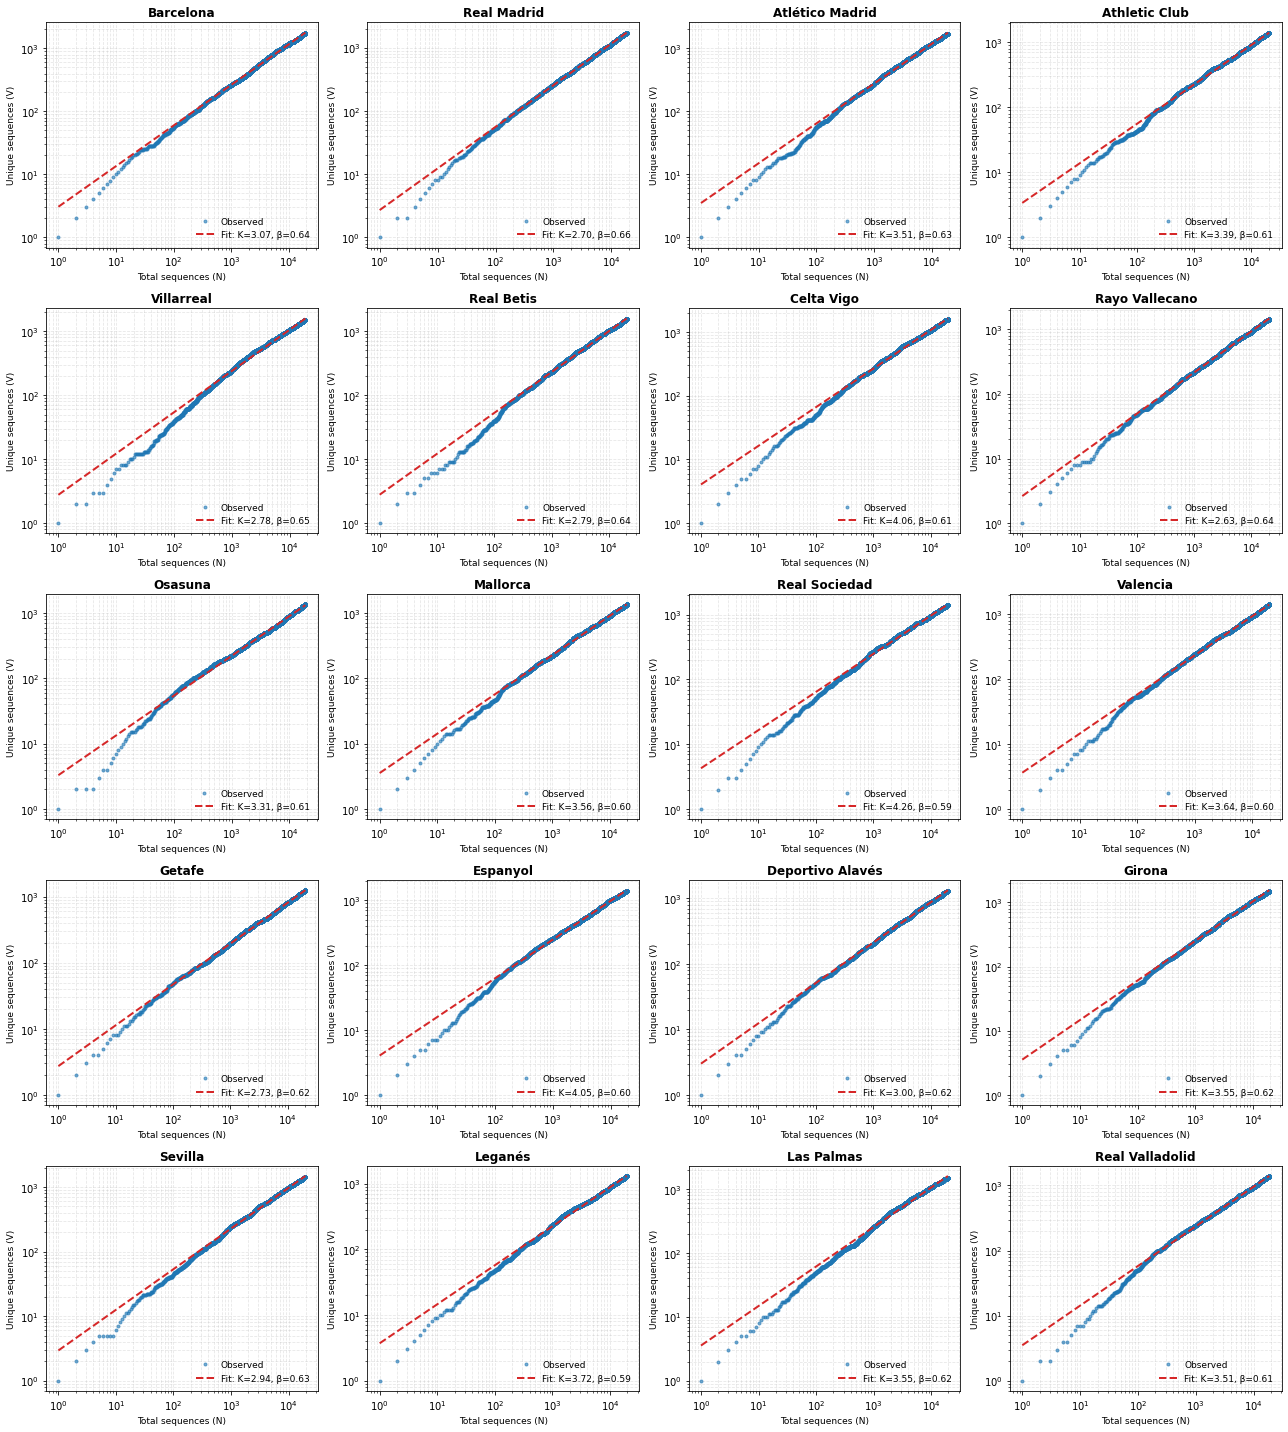

In [49]:
# === Directory con i 20 CSV ===
DIR = "La_Liga_24_25_chapters"

# === Ordine ufficiale delle squadre ===
ranking = [
    "Barcelona",
    "Real Madrid",
    "Atlético Madrid",
    "Athletic Club",
    "Villarreal",
    "Real Betis",
    "Celta Vigo",
    "Rayo Vallecano",
    "Osasuna",
    "Mallorca",
    "Real Sociedad",
    "Valencia",
    "Getafe",
    "Espanyol",
    "Deportivo Alavés",
    "Girona",
    "Sevilla",
    "Leganés",
    "Las Palmas",
    "Real Valladolid",
]

# === Funzione per calcolare Heaps (K, β) ===
def compute_heaps_from_words(words_series):
    tokens = list(words_series.astype(str))
    seen = set()
    total_words, unique_words = [], []
    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)
        unique_words.append(len(seen))
    N = np.array(total_words, dtype=float)
    V = np.array(unique_words, dtype=float)
    mask = (N > 0) & (V > 0)
    if mask.sum() < 5 or np.unique(V[mask]).size < 2:
        return N, V, np.nan, np.nan, None
    logN, logV = np.log(N[mask]), np.log(V[mask])
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)
    V_pred = K * (N ** beta)
    return N, V, K, beta, V_pred

# === Mappa {team_name : path} ===
csv_paths = {
    os.path.splitext(f)[0].replace("_", " "): os.path.join(DIR, f)
    for f in os.listdir(DIR)
    if f.endswith(".csv")
}

# === Setup figura 5×4 ===
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 20))
axes = axes.ravel()

# Disattiva assi in eccesso
for ax in axes[len(ranking):]:
    ax.axis("off")

# === Loop con tqdm ===
for i, team in enumerate(tqdm(ranking, desc="Computing Heaps' Law", unit="team")):
    ax = axes[i]
    path = csv_paths.get(team)
    if path is None:
        ax.text(0.5, 0.5, f"{team}\n(No file found)", ha="center", va="center")
        ax.set_axis_off()
        continue

    try:
        df = pd.read_csv(path)
        if "words" not in df.columns or df.empty:
            ax.text(0.5, 0.5, f"{team}\n(No 'words' data)", ha="center", va="center")
            ax.set_axis_off()
            continue

        N, V, K, beta, V_pred = compute_heaps_from_words(df["words"])

        # Plot log–log
        ax.loglog(N, V, ".", alpha=0.6, label="Observed")
        if V_pred is not None and np.isfinite(K) and np.isfinite(beta):
            ax.loglog(N, V_pred, "--", linewidth=2, color="tab:red",
                      label=f"Fit: K={K:.2f}, β={beta:.2f}")

        # Titolo = solo nome squadra
        ax.set_title(team, fontsize=12, fontweight="bold")

        # Legenda con K e β
        ax.legend(fontsize=9, loc="lower right", frameon=False)

        # Etichette e griglia
        ax.set_xlabel("Total sequences (N)", fontsize=9)
        ax.set_ylabel("Unique sequences (V)", fontsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)

    except Exception as e:
        ax.text(0.5, 0.5, f"{team}\nError: {e}", ha="center", va="center")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig("HeapsLaw_La_Liga_24_25.png", dpi=300, bbox_inches="tight")
plt.show()

## Premier League

Computing Heaps' Law: 100%|██████████| 20/20 [00:03<00:00,  6.07team/s]


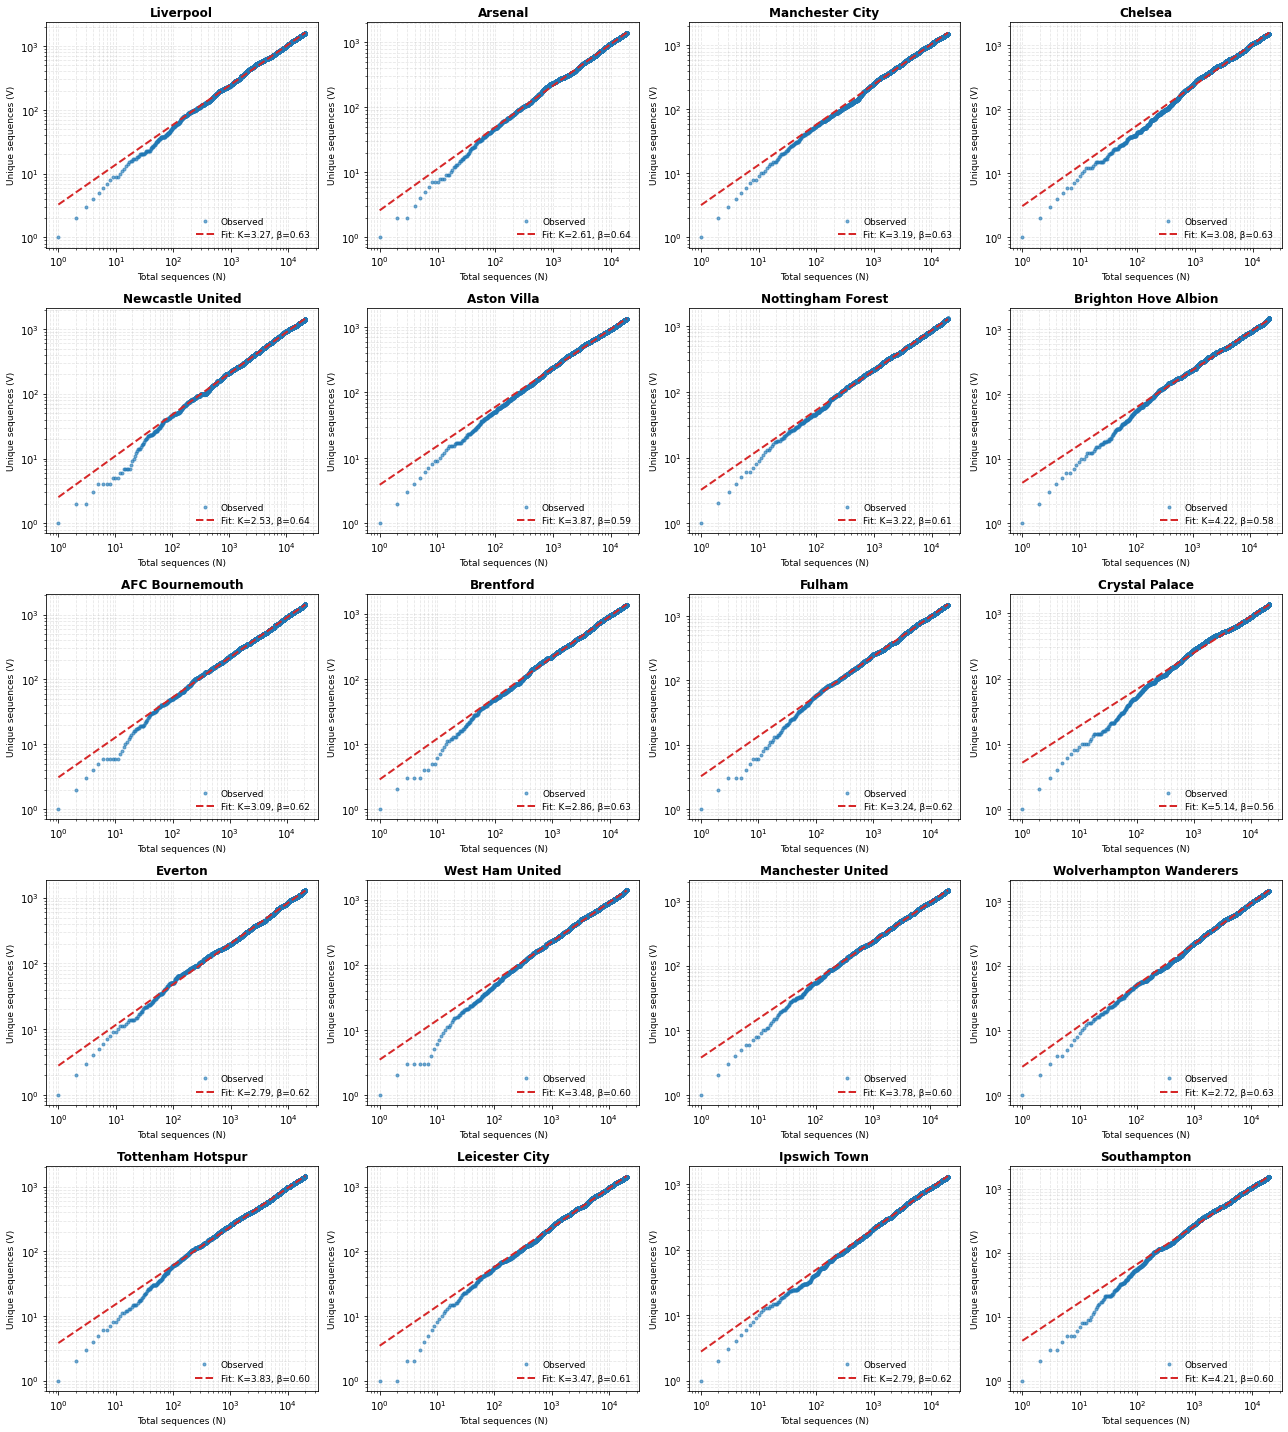

In [51]:
# === Directory con i 20 CSV ===
DIR = "Premier_League_24_25_chapters"

# === Ordine ufficiale delle squadre ===
ranking = [
    "Liverpool",
    "Arsenal",
    "Manchester City",
    "Chelsea",
    "Newcastle United",
    "Aston Villa",
    "Nottingham Forest",
    "Brighton Hove Albion",
    "AFC Bournemouth",
    "Brentford",
    "Fulham",
    "Crystal Palace",
    "Everton",
    "West Ham United",
    "Manchester United",
    "Wolverhampton Wanderers",
    "Tottenham Hotspur",
    "Leicester City",
    "Ipswich Town",
    "Southampton",
]

# === Funzione per calcolare Heaps (K, β) ===
def compute_heaps_from_words(words_series):
    tokens = list(words_series.astype(str))
    seen = set()
    total_words, unique_words = [], []
    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)
        unique_words.append(len(seen))
    N = np.array(total_words, dtype=float)
    V = np.array(unique_words, dtype=float)
    mask = (N > 0) & (V > 0)
    if mask.sum() < 5 or np.unique(V[mask]).size < 2:
        return N, V, np.nan, np.nan, None
    logN, logV = np.log(N[mask]), np.log(V[mask])
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)
    V_pred = K * (N ** beta)
    return N, V, K, beta, V_pred

# === Mappa {team_name : path} ===
csv_paths = {
    os.path.splitext(f)[0].replace("_", " "): os.path.join(DIR, f)
    for f in os.listdir(DIR)
    if f.endswith(".csv")
}

# === Setup figura 5×4 ===
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 20))
axes = axes.ravel()

# Disattiva assi in eccesso
for ax in axes[len(ranking):]:
    ax.axis("off")

# === Loop con tqdm ===
for i, team in enumerate(tqdm(ranking, desc="Computing Heaps' Law", unit="team")):
    ax = axes[i]
    path = csv_paths.get(team)
    if path is None:
        ax.text(0.5, 0.5, f"{team}\n(No file found)", ha="center", va="center")
        ax.set_axis_off()
        continue

    try:
        df = pd.read_csv(path)
        if "words" not in df.columns or df.empty:
            ax.text(0.5, 0.5, f"{team}\n(No 'words' data)", ha="center", va="center")
            ax.set_axis_off()
            continue

        N, V, K, beta, V_pred = compute_heaps_from_words(df["words"])

        # Plot log–log
        ax.loglog(N, V, ".", alpha=0.6, label="Observed")
        if V_pred is not None and np.isfinite(K) and np.isfinite(beta):
            ax.loglog(N, V_pred, "--", linewidth=2, color="tab:red",
                      label=f"Fit: K={K:.2f}, β={beta:.2f}")

        # Titolo = solo nome squadra
        ax.set_title(team, fontsize=12, fontweight="bold")

        # Legenda con K e β
        ax.legend(fontsize=9, loc="lower right", frameon=False)

        # Etichette e griglia
        ax.set_xlabel("Total sequences (N)", fontsize=9)
        ax.set_ylabel("Unique sequences (V)", fontsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)

    except Exception as e:
        ax.text(0.5, 0.5, f"{team}\nError: {e}", ha="center", va="center")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig("HeapsLaw_Premier_League_24_25.png", dpi=300, bbox_inches="tight")
plt.show()

## Bundesliga

Computing Heaps' Law: 100%|██████████| 18/18 [00:02<00:00,  7.84team/s]


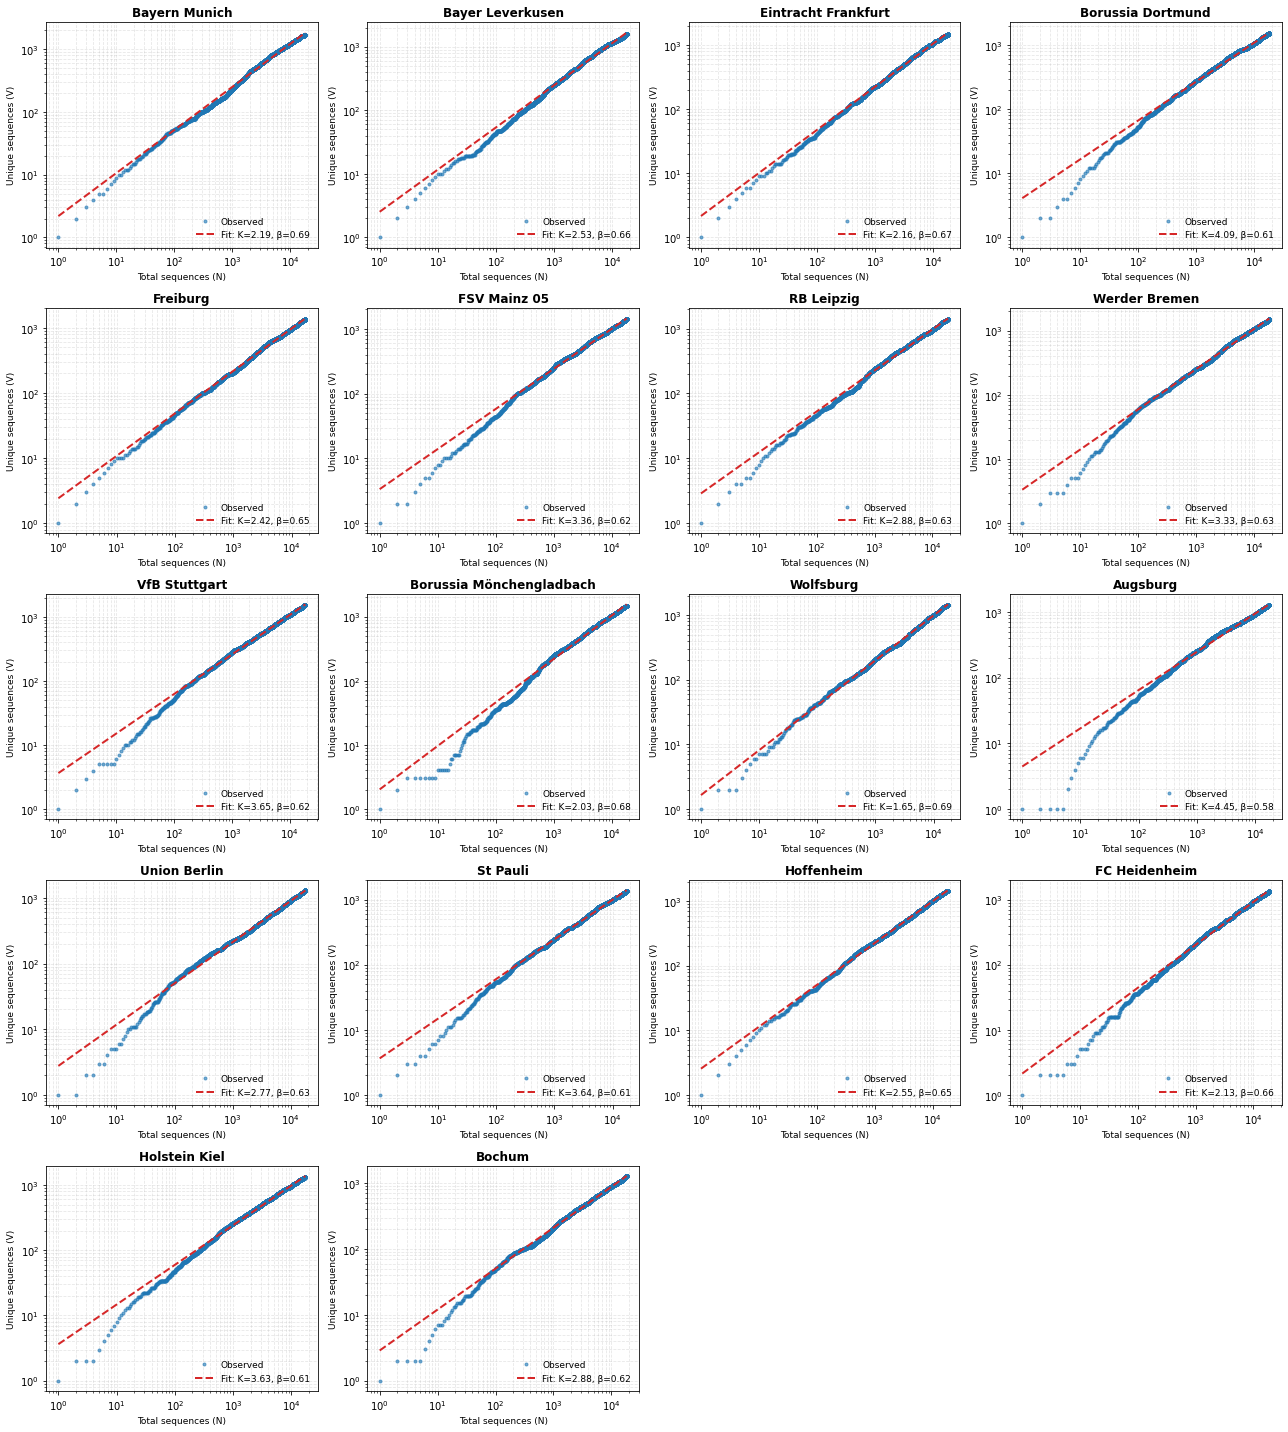

In [54]:
DIR = "Bundesliga_24_25_chapters"

ranking = [
    "Bayern Munich",              
    "Bayer Leverkusen",           
    "Eintracht Frankfurt",        
    "Borussia Dortmund",          
    "Freiburg",                   
    "FSV Mainz 05",               
    "RB Leipzig",                 
    "Werder Bremen",              
    "VfB Stuttgart",              
    "Borussia Mönchengladbach",   
    "Wolfsburg",                  
    "Augsburg",                   
    "Union Berlin",               
    "St Pauli",                  
    "Hoffenheim",                 
    "FC Heidenheim",              
    "Holstein Kiel",              
    "Bochum"                     
]

# === Funzione per calcolare Heaps (K, β) ===
def compute_heaps_from_words(words_series):
    tokens = list(words_series.astype(str))
    seen = set()
    total_words, unique_words = [], []
    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)
        unique_words.append(len(seen))
    N = np.array(total_words, dtype=float)
    V = np.array(unique_words, dtype=float)
    mask = (N > 0) & (V > 0)
    if mask.sum() < 5 or np.unique(V[mask]).size < 2:
        return N, V, np.nan, np.nan, None
    logN, logV = np.log(N[mask]), np.log(V[mask])
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)
    V_pred = K * (N ** beta)
    return N, V, K, beta, V_pred

# === Mappa {team_name : path} ===
csv_paths = {
    os.path.splitext(f)[0].replace("_", " "): os.path.join(DIR, f)
    for f in os.listdir(DIR)
    if f.endswith(".csv")
}

# === Setup figura 5×4 ===
rows, cols = 5, 4
fig, axes = plt.subplots(rows, cols, figsize=(18, 20))
axes = axes.ravel()

# Disattiva assi in eccesso
for ax in axes[len(ranking):]:
    ax.axis("off")

# === Loop con tqdm ===
for i, team in enumerate(tqdm(ranking, desc="Computing Heaps' Law", unit="team")):
    ax = axes[i]
    path = csv_paths.get(team)
    if path is None:
        ax.text(0.5, 0.5, f"{team}\n(No file found)", ha="center", va="center")
        ax.set_axis_off()
        continue

    try:
        df = pd.read_csv(path)
        if "words" not in df.columns or df.empty:
            ax.text(0.5, 0.5, f"{team}\n(No 'words' data)", ha="center", va="center")
            ax.set_axis_off()
            continue

        N, V, K, beta, V_pred = compute_heaps_from_words(df["words"])

        # Plot log–log
        ax.loglog(N, V, ".", alpha=0.6, label="Observed")
        if V_pred is not None and np.isfinite(K) and np.isfinite(beta):
            ax.loglog(N, V_pred, "--", linewidth=2, color="tab:red",
                      label=f"Fit: K={K:.2f}, β={beta:.2f}")

        # Titolo = solo nome squadra
        ax.set_title(team, fontsize=12, fontweight="bold")

        # Legenda con K e β
        ax.legend(fontsize=9, loc="lower right", frameon=False)

        # Etichette e griglia
        ax.set_xlabel("Total sequences (N)", fontsize=9)
        ax.set_ylabel("Unique sequences (V)", fontsize=9)
        ax.grid(True, which="both", linestyle="--", alpha=0.3)

    except Exception as e:
        ax.text(0.5, 0.5, f"{team}\nError: {e}", ha="center", va="center")
        ax.set_axis_off()

plt.tight_layout()
plt.savefig("Bundesliga_24_25.png", dpi=300, bbox_inches="tight")
plt.show()

## Add K and beta to each csv

In [88]:
INPUT_DIR = "La_Liga_24_25_texts"  # folder containing match CSVs

def compute_heaps_params(words_series):
    """
    Compute K and β from Heaps' Law: V = K * N^β
    using V = number of unique sequences after N rows.
    """
    tokens = list(words_series.astype(str))
    seen = set()
    total_words, unique_words = [], []

    for i, tok in enumerate(tokens, start=1):
        seen.add(tok)
        total_words.append(i)
        unique_words.append(len(seen))

    N = np.array(total_words, dtype=float)
    V = np.array(unique_words, dtype=float)

    logN, logV = np.log(N), np.log(V)
    beta, logK = np.polyfit(logN, logV, 1)
    K = np.exp(logK)

    return float(K), float(beta)

# Collect all CSV files
csv_paths = [
    os.path.join(INPUT_DIR, f)
    for f in sorted(os.listdir(INPUT_DIR))
    if f.endswith(".csv")
]

# Loop through all matches with tqdm progress bar
for path in tqdm(csv_paths, desc="Computing Heaps' Law (K, β)", unit="file"):
    df = pd.read_csv(path)
    K, beta = compute_heaps_params(df["words"])
    df["K"] = K
    df["beta"] = beta
    df.to_csv(path, index=False, encoding="utf-8")


Computing Heaps' Law (K, β): 100%|██████████| 760/760 [00:25<00:00, 29.33file/s]


## Chapters

In [92]:
INPUT_DIR = "Serie_A_24_25_texts"
OUTPUT_DIR = "Serie:_24_25_chapters"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def safe_key(s: str) -> str:
    return re.sub(r"\W+", "_", str(s).strip())

# Raccogli tutti i CSV per team
by_team = {}
csv_files = sorted(glob(os.path.join(INPUT_DIR, "*.csv")))

for path in tqdm(csv_files, desc="Reading CSVs", unit="file"):
    try:
        df = pd.read_csv(path)
        if df.empty or "team_name" not in df.columns:
            continue
        team = str(df.iloc[0]["team_name"]).strip()
        by_team.setdefault(team, []).append(df)
    except Exception as e:
        tqdm.write(f"⚠️ Skipped {os.path.basename(path)}: {e}")

# Concatena e salva un CSV per squadra
for team, dfs in tqdm(by_team.items(), desc="Writing team chapters", unit="team"):
    try:
        stacked = pd.concat(dfs, ignore_index=True)
        # (opzionale) ordina per match_id se presente
        if "match_id" in stacked.columns:
            stacked = stacked.sort_values("match_id").reset_index(drop=True)
        out_path = os.path.join(OUTPUT_DIR, f"{safe_key(team)}.csv")
        stacked.to_csv(out_path, index=False, encoding="utf-8")
    except Exception as e:
        tqdm.write(f"❌ Error for team {team}: {e}")

Writing team chapters: 100%|██████████| 20/20 [00:08<00:00,  2.32team/s]
